## Prepping the data from the previous chapter

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
data_path = "../data_unversioned/p1ch7/"
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4741, 0.4727, 0.4733), # the function doesnt calculate it, we have to do that ourselves
        (0.2521, 0.2520, 0.2506)
    )
]))
transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4741, 0.4727, 0.4733), # the function doesnt calculate it, we have to do that ourselves
        (0.2521, 0.2520, 0.2506)
    )
]))



In [3]:
# get only birds and airplanes
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label])for img, label in transformed_cifar10_val if label in [0, 2]]

## introducing convolutions and pooling

In [4]:
# 3 - input features - R,G,B per pixel
# 16 - output features - arbitrary - will result in 16 features for the model to work with. 
# ie, 16 kernels will be learnt and be slid around
conv = nn.Conv2d(3, 16, kernel_size=3, padding=True)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


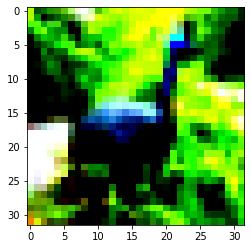

In [5]:
img_t, _ = cifar2[0]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [6]:
with torch.no_grad():conv.bias.zero_()
# to get mean of it's neighbours, = 1/9(sum(3x3=9 pixels)) - a blurring kernel
with torch.no_grad():conv.weight.fill_(1.0 / 9.0)


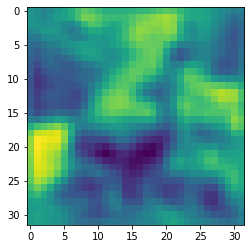

In [13]:
output = conv(img_t.unsqueeze(0))
# [0,0] is indexing the first image in the tensor
plt.imshow(output[0, 0].detach())
plt.show()

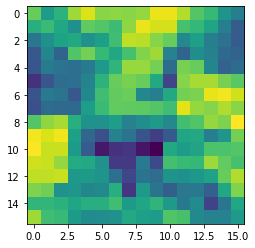

In [14]:
# reduce image size by keeping the max pixel value in a 2x2 neighbourhood- halving the pixels needed
pool = nn.MaxPool2d(2)
output = pool(img_t.unsqueeze(0))
plt.imshow(output[0, 0].detach())
plt.show()

## making the model


In [29]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=True),
    nn.Tanh(), # the nonlinearity makes it a neural network
    nn.MaxPool2d(2), #16x16 img
    nn.Conv2d(16, 8, kernel_size=3, padding=True),
    nn.Tanh(), # the nonlinearity makes it a neural network
    nn.MaxPool2d(2), #8x8 img, from 8 kernels => 8x8x8
    nn.Flatten(), # make the maxpooling and convolutional layers into a 1d tensor
    nn.Linear(8*8*8,32),
    nn.Tanh(),
    nn.Linear(32, 2)

)
model(img_t.unsqueeze(0))

tensor([[-0.1510,  0.1857]], grad_fn=<AddmmBackward>)

In [30]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

We can use a `nn.Flatten` layer to make the `8x8x8` tensor `1D` like above, but for finer grained control, let's learn how to create a `nn.Module` class!

We define the layers and activations in the `__init__` method, and perform operations on them in the `forward` method

In [37]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh() # the nonlinearity makes it a neural network
        self.pool1 = nn.MaxPool2d(2) #16x16 img
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh() # the nonlinearity makes it a neural network
        self.pool2 = nn.MaxPool2d(2) #8x8 img, from 8 kernels => 8x8x8
        self.fc1 = nn.Linear(8*8*8,32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    def forward(self, batch):
        # can do more than just chaining in this function!
        out = self.pool1(self.act1(self.conv1(batch)))
        out = self.pool2(self.act2(self.conv2(out)))
        # because we don't know the batch size, let that be -1
        out = out.view(-1, 8*8*8) 
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

    

In [38]:
# print number of parameters
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

## pytorch functional api

We want to keep the conv and linear layers in the `__init__`, but `TanH` and `pooling` don't have any parameters to train on, so it's annoying to define them in `__init__`

We can define them directly in the foward pass with their functional counterparts! (Ones that don't have internal state, but whose outputs are completely determined by the parameters passed into them.)

In [44]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*8,32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, batch):
        # can do more than just chaining in this function!
        out = F.max_pool2d(torch.tanh(self.conv1(batch)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        # because we don't know the batch size, let that be -1
        out = out.view(-1, 8*8*8) 
        out = torch.tanh(self.fc1(out))
        # recall : a normal linear output + CrossEntropyLoss = LogSoftmax layer output+NLL loss. We simply choose the prior here.
        out = self.fc2(out) 
        return out

In [45]:
# print number of parameters
model = Net()
model(img_t.unsqueeze(0))

tensor([[ 0.0510, -0.0993]], grad_fn=<AddmmBackward>)

### training

In [46]:
from datetime import datetime

def training_loop(n_epochs, optimizer, loss_fn, train_loader):
    for i in range(1,n_epochs+1):
        train_loss=0
        for imgs,labels in train_loader:
            optimizer.zero_grad() # to prevent accumulation of gradients in every iteration

            predicted_labels = model(imgs)
            loss = loss_fn(predicted_labels, labels) 
            loss.backward() # calc gradients
            optimizer.step() # update params
            train_loss += loss.item() # .item() makes the 1d tensor a normal number. might be effected by gradients if we dont do that.
        if i==1 or i%10==0 :
            print(f"[{datetime.now()}] epoch {i} avg training loss per batch {train_loss/len(train_loader)}")

In [48]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=True)
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader
)

[2021-06-11 11:12:31.494472] epoch 1 avg training loss per batch 0.5828628967142409
[2021-06-11 11:12:46.161091] epoch 10 avg training loss per batch 0.32597023580863976
[2021-06-11 11:13:03.252651] epoch 20 avg training loss per batch 0.29612610000333967
[2021-06-11 11:13:21.214713] epoch 30 avg training loss per batch 0.27039896084624493
[2021-06-11 11:13:37.807292] epoch 40 avg training loss per batch 0.2489252023541244
[2021-06-11 11:13:54.353593] epoch 50 avg training loss per batch 0.23009411601503943
[2021-06-11 11:14:10.785188] epoch 60 avg training loss per batch 0.21378976664250823
[2021-06-11 11:14:27.741184] epoch 70 avg training loss per batch 0.19505260291562718
[2021-06-11 11:14:43.805959] epoch 80 avg training loss per batch 0.18019832452391363
[2021-06-11 11:14:59.957730] epoch 90 avg training loss per batch 0.1649000705427425
[2021-06-11 11:15:16.833402] epoch 100 avg training loss per batch 0.15087100032977996


The training loss doesn't tell us that much. We look at accuracies (predicted vs expected) for the training and validation sets.

In [66]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,shuffle=True)

# go over every batch and compare the predicted vs expected.
# keep track of total images we predicted right, divide them by total number of images we have

def calculate_accuracy(model, loader):
    total = 0
    correct=0
    for imgs,labels in loader:
        # # because the model output is not softmax, we have to convert it to probabilities 
        # prediction = model(imgs)
        # probabilities = [F.softmax(output).tolist() for output in prediction]
        # # for each probability pair, we want the index of the max value
        # labels_predicted = [l.index(max(l)) for l in probabilities]
        # for i, item in enumerate(labels_predicted):
        #     total+=1
        #     if labels_predicted[i]==labels[i]:
        #         correct+=1

        # or

        prediction = model(imgs)
        _, labels_predicted = torch.max(prediction, dim=1) # softmax preserves order, so we don't really have to apply it here. the max result will be the same.
        total+=labels.shape[0] # batch size at 0th index
        correct += int((labels_predicted==labels).sum()) 


    return correct/total

print(f"train {calculate_accuracy(model, train_loader)}")
print(f"val {calculate_accuracy(model, val_loader)}")


train 0.8941
val 0.8475


## training on the GPU
- As per usual convention, you will have to move the tensors onto the respective device (`gpu` or `cpu`)
- we use `.to()`
    - `model.to` is _in place_
    - `tensor.to` is not, it returns a new tensor on the device
    

In [68]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
device

device(type='cuda')

In [69]:
from datetime import datetime

def training_loop(n_epochs, optimizer, loss_fn, train_loader):
    for i in range(1,n_epochs+1):
        train_loss=0
        for imgs,labels in train_loader:
            optimizer.zero_grad() 
            ### move data to gpu (returns a tensor, so reassign)
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            ###
            predicted_labels = model(imgs)
            loss = loss_fn(predicted_labels, labels) 
            loss.backward() 
            optimizer.step()
            train_loss += loss.item() 
        if i==1 or i%10==0 :
            print(f"[{datetime.now()}] epoch {i} avg training loss per batch {train_loss/len(train_loader)}")

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=True)
## move model parameters to GPU in place
model = Net().to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader
)

[2021-06-11 15:37:43.310713] epoch 1 avg training loss per batch 0.5513810969082413
[2021-06-11 15:37:48.398021] epoch 10 avg training loss per batch 0.3261571797026191
[2021-06-11 15:37:54.054740] epoch 20 avg training loss per batch 0.2913062528819795
[2021-06-11 15:38:00.339158] epoch 30 avg training loss per batch 0.26688439954238335
[2021-06-11 15:38:06.284793] epoch 40 avg training loss per batch 0.24876307463570005
[2021-06-11 15:38:11.801687] epoch 50 avg training loss per batch 0.2299839769768867
[2021-06-11 15:38:17.289746] epoch 60 avg training loss per batch 0.21285620251089143
[2021-06-11 15:38:23.418340] epoch 70 avg training loss per batch 0.20052622951519716
[2021-06-11 15:38:28.944768] epoch 80 avg training loss per batch 0.1843588383524281
[2021-06-11 15:38:34.717610] epoch 90 avg training loss per batch 0.16894880181569963
[2021-06-11 15:38:40.314760] epoch 100 avg training loss per batch 0.15628607575870623


> we can save models and load it ignoring the device the model was saved from